In [1]:
# Práctica 7: ML US
# LIBRERIAS NECESARIAS (si os hacen falta más, debéis añadirlas)

import keras
import numpy as np
import os
import skimage
from PIL import Image
from skimage import measure
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from metricas import *


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Definimos algunas funciones que usaremos
"Function to plot learning and loss results from CNN training"    
def Learning_results(results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

def metricas(Mt_confusion):
    
    VP = Mt_confusion[0,0]
    FP = Mt_confusion[0,1]
    FN = Mt_confusion[1,0]
    VN = Mt_confusion[1,1]
    
    Acuraccy = (VP+VN)/(VP+FP+FN+VN)
    Sensibilidad = VP/(VP+FN)
    Especificidad = VN/(VN+FP)
    VPP = VP/(VP+FP) # Valor predictivo positivo
    VPN = VN/(VN + FN) # Valor predictivo negativo
    F1 = 2*Sensibilidad*VPP / (Sensibilidad+VPP)

    print("Matriz de confusion: "+str(Mt_confusion)+"\n")
    print("Accuracy: "+str(Acuraccy))
    print("Sensibilidad: "+str(Sensibilidad))
    print("Especificidad: "+str(Especificidad))
    print("F1 Score: "+str(F1))
    print("Valor Predictivo Positivo: "+str(VPP))
    print("Valor Predictivo Negativo: "+str(VPN))


# CARGAMOS LAS IMÁGENES

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Dataset_BUSI_with_GT')
from metricas import *


In [3]:
# LAS SIGUIENTES ÓRDENES GUARDAN UN LISTADO DE LAS IMÁGENES DE LOS DIRECTORIOS ORIGINAL Y MÁSCARA. DEBÉIS REPETIRLO PARA TODOS LOS DIRECTORIOS QUE TENÉIS EN P6_IA

# Imagenes benignas
lista_benignos = os.listdir(os.getcwd()+'/Dataset_BUSI_with_GT/benign/')
lista_benignos.sort()

# Remove .DS_Store file if exists:
if lista_benignos[0] == '.DS_Store':
    lista_benignos.pop(0)
    

# Imagenes malignas
lista_malignos = os.listdir(os.getcwd()+'/Dataset_BUSI_with_GT/malignant/')
lista_malignos.sort()

# Remove .DS_Store file if exists:
if lista_malignos[0] == '.DS_Store':
    lista_malignos.pop(0)
    

# Imagenes normales
lista_normales = os.listdir(os.getcwd()+'/Dataset_BUSI_with_GT/normal/')
lista_normales.sort()

# Remove .DS_Store file if exists:
if lista_normales[0] == '.DS_Store':
    lista_normales.pop(0)



# Extracción y selección de características

## En primer lugar extraemos las características seleccionadas

In [4]:
# Imágenes benignas
Images = []

for k1 in lista_benignos:
    img = os.getcwd()+'/Dataset_BUSI_with_GT/benign/'+k1
    image1 = img_to_array(load_img(img, target_size=(400,400)))
    Images.append(image1);

for k1 in lista_malignos:
    img = os.getcwd()+'/Dataset_BUSI_with_GT/malignant/'+k1
    image1 = img_to_array(load_img(img, target_size=(400,400)))
    Images.append(image1); 

for k1 in lista_normales:
    img = os.getcwd()+'/Dataset_BUSI_with_GT/normal/'+k1
    image1 = img_to_array(load_img(img, target_size=(400,400)))
    Images.append(image1); 


In [5]:
# Crear verdad de referencia
Y = np.zeros((len(Images),3))

idx = list(range(len(lista_benignos)))
idx2 = list(range(idx[-1]+1,len(lista_malignos)+idx[-1]+1))
idx3 = list(range(idx2[-1]+1,len(lista_normales)+idx2[-1]+1))

Y[idx,0] = 1
Y[idx2,1] = 1
Y[idx3,2] = 1


In [6]:
# Separar conjuntos de entrenamiento, validacion y test
#Images_aux = np.zeros((len(Images),Images[0].shape[0], Images[0].shape[1],3))

for k1 in range(len(Images)):

    cropnorm = np.array(Images[k1], dtype=np.float32)
    
    # Normalizamos para tener la imagen en el rango [0,1]
    cropnorm = cropnorm - cropnorm.min() 
    cropnorm = cropnorm / cropnorm.max()
    
    # Almacenamos el crop normaizado
    Images[k1] = np.reshape(cropnorm,(400,400,3))

np.random.seed(71)
idxTrain = np.random.permutation(len(np.array(Images)))
Images = np.array(Images)[idxTrain,:,:,:]
Y = Y[idxTrain,:]

th1 = int(.7*(len(Y)))
th2 = int(.9*(len(Y)))

# Generate train, validation and test sets:
X_train = np.array(Images[0:th1], dtype=np.float32)
X_valid = np.array(Images[th1+1:th2], dtype=np.float32)
X_test = np.array(Images[th2+1:len(Images)], dtype=np.float32)
Y_train = np.array(Y[0:th1], dtype=np.float32)
Y_valid = np.array(Y[th1+1:th2], dtype=np.float32)
Y_test = np.array(Y[th2+1:len(Y)], dtype=np.float32)
del Images, Y


In [8]:
base_model = VGG16(include_top=False, weights="imagenet", input_tensor=None, input_shape=(None),pooling=None, classes=3, classifier_activation="softmax")
base_model.trainable = False

model = models.Sequential([base_model])
model.add(Flatten())
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))
model.build((None,400,400,3))
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 12, 12, 512)       14714688  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 73728)             0         
_________________________________________________________________
dropout (Dropout)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 221187    
Total params: 14,935,875
Trainable params: 221,187
Non-trainable params: 14,714,688
_________________________________________________________________


2023-01-23 22:44:14.500137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-23 22:44:14.500418: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-23 22:44:14.668239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 2.7705 - accuracy: 0.4524

2023-01-23 22:44:28.178386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 917ms/step - loss: 2.7705 - accuracy: 0.4524 - val_loss: 0.8699 - val_accuracy: 0.6839
Epoch 2/10
18/18 [==============================] - 16s 893ms/step - loss: 0.7731 - accuracy: 0.7198 - val_loss: 0.7877 - val_accuracy: 0.7161
Epoch 3/10
18/18 [==============================] - 16s 889ms/step - loss: 0.6287 - accuracy: 0.7619 - val_loss: 0.8133 - val_accuracy: 0.6581
Epoch 4/10
18/18 [==============================] - 16s 905ms/step - loss: 0.4100 - accuracy: 0.8443 - val_loss: 0.7955 - val_accuracy: 0.6903
Epoch 5/10
18/18 [==============================] - 16s 907ms/step - loss: 0.2016 - accuracy: 0.9267 - val_loss: 0.4561 - val_accuracy: 0.8258
Epoch 6/10
18/18 [==============================] - 16s 900ms/step - loss: 0.1393 - accuracy: 0.9634 - val_loss: 0.6007 - val_accuracy: 0.7806
Epoch 7/10
18/18 [==============================] - 16s 914ms/step - loss: 0.1365 - accuracy: 0.9579 - val_loss: 0.5471 - val_accuracy: 0.7613
Epoch 8/10

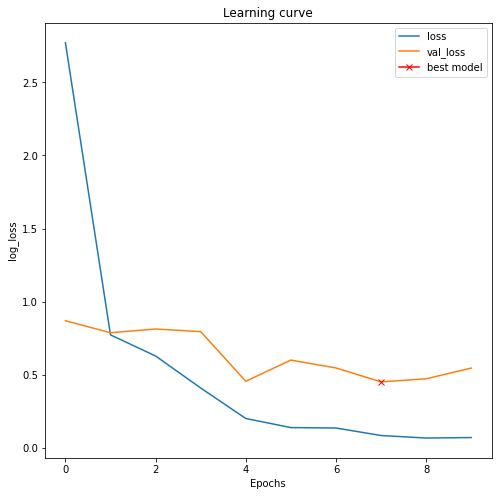

In [9]:
results = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
Learning_results(results)

In [10]:
pred = model.predict(X_test)
clasificacion_test = (np.argmax(pred,axis=1))
referencia = np.argmax(Y_test,axis=1)
porcent_error = np.count_nonzero(clasificacion_test-referencia)/len(clasificacion_test)
print('Porcentaje de error: '+str(porcent_error))

2023-01-23 22:47:21.009399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Porcentaje de error: 0.14102564102564102


In [11]:
# Calculamos la matriz de confusion

# Tomamos las referencias
referencia_benignos = np.where((clasificacion_test==0) | (clasificacion_test==2))
referencia_malignos = np.where(clasificacion_test==1)

# Miro cuánto vale la verdad de referencia donde la red predice que es benigno
comparacion_benignos = referencia[referencia_benignos]

# Si la referencia vale 1, la red esta detectando un falso negativo
FN = len(np.where(comparacion_benignos==1)[0])

# Si la referencia vale 0 o 2, la red esta detectando un verdadero negativo
VN = len(comparacion_benignos)-FN


# Miro cuánto vale la verdad de referencia donde la red predice que es benigno
comparacion_malignos = referencia[referencia_malignos]

# Si la referencia vale 1, la red esta detectando un verdadero positivo
VP = len(np.where(comparacion_malignos==1)[0])

# Si la referencia vale 0 o 2, la red esta detectando un falso positivo
FP = len(comparacion_malignos)-VP


Mt_confusion = np.zeros((2,2))
# Incorporamos VP, VN, FP, FN a la matriz de confusion
Mt_confusion[0,0] = VP
Mt_confusion[0,1] = FP
Mt_confusion[1,0] = FN
Mt_confusion[1,1] = VN  


In [12]:
# Calculamos las metricas para evaluar como de buena es la clasificacion
metricas(Mt_confusion)

Matriz de confusion: [[13.  2.]
 [ 4. 59.]]

Accuracy: 0.9230769230769231
Sensibilidad: 0.7647058823529411
Especificidad: 0.9672131147540983
F1 Score: 0.8125
Valor Predictivo Positivo: 0.8666666666666667
Valor Predictivo Negativo: 0.9365079365079365
